In [40]:
import numpy as np
import pandas as pd
import os
from rdkit import Chem
from scipy.spatial.distance import cdist
from itertools import product
import glob
from scipy.stats import rankdata
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

### Loading useful data

### For ECIF

In [13]:
# Possible predefined protein atoms
ECIF_ProteinAtoms = ['C;4;1;3;0;0', 'C;4;2;1;1;1', 'C;4;2;2;0;0', 'C;4;2;2;0;1',
                     'C;4;3;0;0;0', 'C;4;3;0;1;1', 'C;4;3;1;0;0', 'C;4;3;1;0;1',
                     'C;5;3;0;0;0', 'C;6;3;0;0;0', 'N;3;1;2;0;0', 'N;3;2;0;1;1',
                     'N;3;2;1;0;0', 'N;3;2;1;1;1', 'N;3;3;0;0;1', 'N;4;1;2;0;0',
                     'N;4;1;3;0;0', 'N;4;2;1;0;0', 'O;2;1;0;0;0', 'O;2;1;1;0;0',
                     'S;2;1;1;0;0', 'S;2;2;0;0;0']

# Possible ligand atoms according to the PDBbind 2016 "refined set"
ECIF_LigandAtoms = ['Br;1;1;0;0;0', 'C;3;3;0;1;1', 'C;4;1;1;0;0', 'C;4;1;2;0;0',
                     'C;4;1;3;0;0', 'C;4;2;0;0;0', 'C;4;2;1;0;0', 'C;4;2;1;0;1',
                     'C;4;2;1;1;1', 'C;4;2;2;0;0', 'C;4;2;2;0;1', 'C;4;3;0;0;0',
                     'C;4;3;0;0;1', 'C;4;3;0;1;1', 'C;4;3;1;0;0', 'C;4;3;1;0;1',
                     'C;4;4;0;0;0', 'C;4;4;0;0;1', 'C;5;3;0;0;0', 'C;5;3;0;1;1',
                     'C;6;3;0;0;0', 'Cl;1;1;0;0;0', 'F;1;1;0;0;0', 'I;1;1;0;0;0',
                     'N;3;1;0;0;0', 'N;3;1;1;0;0', 'N;3;1;2;0;0', 'N;3;2;0;0;0',
                     'N;3;2;0;0;1', 'N;3;2;0;1;1', 'N;3;2;1;0;0', 'N;3;2;1;0;1',
                     'N;3;2;1;1;1', 'N;3;3;0;0;0', 'N;3;3;0;0;1', 'N;3;3;0;1;1',
                     'N;4;1;2;0;0', 'N;4;1;3;0;0', 'N;4;2;1;0;0', 'N;4;2;2;0;0',
                     'N;4;2;2;0;1', 'N;4;3;0;0;0', 'N;4;3;0;0;1', 'N;4;3;1;0;0',
                     'N;4;3;1;0;1', 'N;4;4;0;0;0', 'N;4;4;0;0;1', 'N;5;2;0;0;0',
                     'N;5;3;0;0;0', 'N;5;3;0;1;1', 'O;2;1;0;0;0', 'O;2;1;1;0;0',
                     'O;2;2;0;0;0', 'O;2;2;0;0;1', 'O;2;2;0;1;1', 'P;5;4;0;0;0',
                     'P;6;4;0;0;0', 'P;6;4;0;0;1', 'P;7;4;0;0;0', 'S;2;1;0;0;0',
                     'S;2;1;1;0;0', 'S;2;2;0;0;0', 'S;2;2;0;0;1', 'S;2;2;0;1;1',
                     'S;3;3;0;0;0', 'S;3;3;0;0;1', 'S;4;3;0;0;0', 'S;6;4;0;0;0',
                     'S;6;4;0;0;1', 'S;7;4;0;0;0']

PossibleECIF = [i[0]+"-"+i[1] for i in product(ECIF_ProteinAtoms, ECIF_LigandAtoms)]

### For ELEMENTS

In [14]:
ELEMENTS_ProteinAtoms = ["C","N","O", "S"]
ELEMENTS_LigandAtoms = ["Br", "C", "Cl", "F", "I", "N", "O", "P", "S"]
PossibleELEMENTS = [i[0]+"-"+i[1] for i in product(ELEMENTS_ProteinAtoms, ELEMENTS_LigandAtoms)]

# An atom type from EFIC is defined as:
    Atom symbol;
    Explicit valence;
    Attached heavy atoms;
    Attached hydrogens;
    Aromaticity;
    Ring membership

In [15]:
def GetAtomType(atom):
# This function takes an atom in a molecule and returns its type as defined for ECIF
    
    AtomType = [atom.GetSymbol(),
                str(atom.GetExplicitValence()),
                str(len([x.GetSymbol() for x in atom.GetNeighbors() if x.GetSymbol() != "H"])),
                str(len([x.GetSymbol() for x in atom.GetNeighbors() if x.GetSymbol() == "H"])),
                str(int(atom.GetIsAromatic())),
                str(int(atom.IsInRing())), 
               ]

    return(";".join(AtomType))

### Ligands are loaded from an SDF file in a dataframe format considering the atom type definitions

In [26]:
def LoadSDFasDF(SDF):
# This function takes an SDF for a ligand as input and returns it as a pandas DataFrame with its atom types labeled according to ECIF
    
    m = Chem.MolFromMolFile(SDF, sanitize=False)
    m.UpdatePropertyCache(strict=False)
    
    ECIF_atoms = []

    for atom in m.GetAtoms():
        if atom.GetSymbol() != "H": # Include only non-hydrogen atoms
            entry = [int(atom.GetIdx())]
            entry.append(GetAtomType(atom))
            pos = m.GetConformer().GetAtomPosition(atom.GetIdx())
            entry.append(float("{0:.4f}".format(pos.x)))
            entry.append(float("{0:.4f}".format(pos.y)))
            entry.append(float("{0:.4f}".format(pos.z)))
            ECIF_atoms.append(entry)

    df = pd.DataFrame(ECIF_atoms)
    df.columns = ["ATOM_INDEX", "ECIF_ATOM_TYPE","X","Y","Z"]
    """if len(set(df["ECIF_ATOM_TYPE"]) - set(ECIF_LigandAtoms)) > 0:
        print("WARNING: Ligand contains unsupported atom types. Only supported atom-type pairs are counted.")
"""    
    return(df)

In [27]:
Atom_Keys=pd.read_csv("PDB_Atom_Keys.csv", sep=",")
def LoadPDBasDF(PDB):
# This function takes a PDB for a protein as input and returns it as a pandas DataFrame with its atom types labeled according to ECIF

    ECIF_atoms = []
    
    f = open(PDB)
    for i in f:
        if i[:4] == "ATOM":
            # Include only non-hydrogen atoms
            if (len(i[12:16].replace(" ","")) < 4 and i[12:16].replace(" ","")[0] != "H") or (len(i[12:16].replace(" ","")) == 4 and i[12:16].replace(" ","")[1] != "H" and i[12:16].replace(" ","")[0] != "H"):
                ECIF_atoms.append([int(i[6:11]),
                         i[17:20]+"-"+i[12:16].replace(" ",""),
                         float(i[30:38]),
                         float(i[38:46]),
                         float(i[46:54])
                        ])
                
    f.close()
    
    df = pd.DataFrame(ECIF_atoms, columns=["ATOM_INDEX","PDB_ATOM","X","Y","Z"])
    df = df.merge(Atom_Keys, left_on='PDB_ATOM', right_on='PDB_ATOM')[["ATOM_INDEX", "ECIF_ATOM_TYPE", "X", "Y", "Z"]].sort_values(by="ATOM_INDEX").reset_index(drop=True)
    '''if list(df["ECIF_ATOM_TYPE"].isna()).count(True) > 0:
        print("WARNING: Protein contains unsupported atom types. Only supported atom-type pairs are counted.")'''
    return(df)

In [18]:
def GetPLPairs(PDB_protein, SDF_ligand, distance_cutoff=6.0):
# This function returns the protein-ligand atom-type pairs for a given distance cutoff
    
    # Load both structures as pandas DataFrames
    Target = LoadPDBasDF(PDB_protein)
    Ligand = LoadSDFasDF(SDF_ligand)
    
    # Take all atoms from the target within a cubic box around the ligand considering the "distance_cutoff criterion"
    for i in ["X","Y","Z"]:
        Target = Target[Target[i] < float(Ligand[i].max())+distance_cutoff]
        Target = Target[Target[i] > float(Ligand[i].min())-distance_cutoff]
    
    # Get all possible pairs
    Pairs = list(product(Target["ECIF_ATOM_TYPE"], Ligand["ECIF_ATOM_TYPE"]))
    Pairs = [x[0]+"-"+x[1] for x in Pairs]
    Pairs = pd.DataFrame(Pairs, columns=["ECIF_PAIR"])
    Distances = cdist(Target[["X","Y","Z"]], Ligand[["X","Y","Z"]], metric="euclidean")
    Distances = Distances.reshape(Distances.shape[0]*Distances.shape[1],1)
    Distances = pd.DataFrame(Distances, columns=["DISTANCE"])

    Pairs = pd.concat([Pairs,Distances], axis=1)
    Pairs = Pairs[Pairs["DISTANCE"] <= distance_cutoff].reset_index(drop=True)
    # Pairs from ELEMENTS could be easily obtained froms pairs from ECIF
    Pairs["ELEMENTS_PAIR"] = [x.split("-")[0].split(";")[0]+"-"+x.split("-")[1].split(";")[0] for x in Pairs["ECIF_PAIR"]]
    return Pairs

In [28]:
def reduce_pairs(df, idxs=[0], col='ECIF_PAIR', newcol='REDUCED_PAIR'):
    df[newcol] = ""
    for j in idxs:
        df[newcol] += df[col].str.split("-").str[0].str.split(";").str[j]
        if j != idxs[-1]:
            df[newcol] += ""
    df[newcol] += "-"
    for j in idxs:
        df[newcol] += df[col].str.split("-").str[1].str.split(";").str[j]
        if j != idxs[-1]:
            df[newcol] += ""
    return df

def GetPossible(idxs, unique=False):
    df = pd.DataFrame(PossibleECIF, columns=["ECIF_PAIR"])
    df = reduce_pairs(df, idxs=idxs, col='ECIF_PAIR', newcol='REDUCED_PAIR')
    if unique:
        Possible_list = list(df["REDUCED_PAIR"].unique())
    else: 
        Possible_list = list(df["REDUCED_PAIR"])
    return Possible_list

### Calculation of ECIF

In [29]:
def GetECIF(PDB_protein, SDF_ligand, distance_cutoff=6.0):
# Main function for the calculation of ECIF
    Pairs = GetPLPairs(PDB_protein, SDF_ligand, distance_cutoff=distance_cutoff)
    ECIF = [list(Pairs["ECIF_PAIR"]).count(x) for x in PossibleECIF]
    return ECIF

In [30]:
def GetECIF_VB(PDB_protein, SDF_ligand, distance_cutoff=8.0, r0=2.0):
    Pairs = GetPLPairs(PDB_protein, SDF_ligand, distance_cutoff=distance_cutoff)
    Pairs['D1'] = 1. / Pairs['DISTANCE']
    Pairs['LJ'] = 2*(r0/ Pairs['DISTANCE'])**6 - (r0/ Pairs['DISTANCE'])**12
    Pairs = Pairs.groupby('ECIF_PAIR').aggregate({'D1': sum,
                                                  'LJ': sum}).reset_index()
    df = pd.DataFrame(PossibleECIF, columns=['ECIF_PAIR'])
    df = df.merge(Pairs, on='ECIF_PAIR', how='left').fillna(0)
    ecifs_vb = np.append(df.D1.values, df.LJ.values)
    return ecifs_vb

In [31]:
#test feature calculation function
ligand_SDF = "./Dataset_pre_test/Docked_SDFs_ligands/1a0q/1a0q_decoy_01_ligand_02.sdf"
protein_PDB = "./Dataset_pre_test/Docked_PDBs_receptors/1a0q_receptor.pdb"
ecif = GetECIF_VB(protein_PDB, ligand_SDF)
np.unique(ecif)
len(ecif)

## Feature selection and batch run

In [120]:
# Data inputs
def VB_featurization_v2(df, N_select):
    R1 = rankdata(M[:, :N], axis=1, method='min')-1 # rank starts at 0
    R2 = rankdata(M[:, N:], axis=1, method='min')-1 # rank starts at 0
    idx1 = np.argsort(R1.sum(axis=0))
    idx2 = np.argsort(R2.sum(axis=0))
    idx1_max = np.flipud(idx1)
    idx2_max = np.flipud(idx2)
    idx_close = np.append(idx1_max[:(N_select // 2)], idx2_max[:(N_select // 2)])
    df_close = df.iloc[:,[i for i in idx_close]]
    idx_othr = np.append(idx1_max[(N_select // 2):], idx2_max[(N_select // 2):])#index for additional col
    df_pool = pd.DataFrame()
    for idx in [idx1, idx2]:
        idx_othr = idx[(N_select // 2):]
        df_othr = df.iloc[:, idx_othr]

        possible_red_pairs = GetPossible([0,4,5])

        red_pairs = [possible_red_pairs[i] for i in idx_othr]

        df_othr = df_othr.T
        df_othr['red_pair'] = red_pairs

        df_othr = df_othr.groupby(['red_pair']).sum()  # aggregate
        df_othr = df_othr.T
        df_othr
        #df_othr = df_othr.loc[:, df_othr.sum(axis=0) != 0] # remove empty columns

        df_pool = pd.concat([df_pool,df_othr],axis=1)
    small_M = pd.concat([df_close,df_pool],axis=1)
    return small_M

def VB_featurization_v1(df,N_select=400):
    R1 = rankdata(M[:, :N], axis=1, method='min')-1 # rank starts at 0
    R2 = rankdata(M[:, N:], axis=1, method='min')-1 # rank starts at 0
    idx1 = np.argsort(R1.sum(axis=0))
    idx2 = np.argsort(R2.sum(axis=0))
    idx1_max = np.flipud(idx1)
    idx2_max = np.flipud(idx2)
    idx_close = np.append(idx1_max[:(N_select // 2)], idx2_max[:(N_select // 2)])
    df_close = df.iloc[:,[i for i in idx_close]]
    idx_othr = np.append(idx1_max[(N_select // 2):], idx2_max[(N_select // 2):])#index for additional col
        #add element pairs to all data
    Possible_elements = [p.split(";")[0] + "-" + p.split("-")[1].split(";")[0]+"1" for p in PossibleECIF]+[p.split(";")[0] + "-" + p.split("-")[1].split(";")[0]+"6" for p in PossibleECIF]
    df1=df.T
    df1["Possible_elements"] = Possible_elements
        #select additional col by index
    df_othr = df1.iloc[idx_othr,:]
        #obtain sum values of different element pairs respectively
    df_othr_sum = df_othr.groupby(['Possible_elements']).sum()
    df_othr_sum # 1:D1sum, 6:D6sum
    small_M = pd.concat([df_close,df_othr_sum.T],axis=1)
    return small_M



In [123]:
#test featurization function
"""
df = pd.read_csv("./Dataset_pre_test/Inside_output/All_ECIF.csv")
VB_featurization_v1(df, N_select = 200)

"""

'\ndf = pd.read_csv("./Dataset_pre_test/Inside_output/All_ECIF.csv")\nVB_featurization_v1(df, N_select = 200)\n\n'

In [140]:
#test run for multipose data from SCORCH
def batchrun_ECIF():
    output_path = "./Dataset_pre_test/Inside_output/"
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    protein_file_path = './Dataset_pre_test/Docked_PDBs_receptors/*.pdb'
    protein_files = glob.glob(protein_file_path)    
    N = 1540 # number of default features from original ECIF 
    for p in protein_files:
        pdb = p.split("/")[-1].replace("_receptor.pdb", "")
        ligand_file_path = './Dataset_pre_test/Docked_SDFs_ligands/'+pdb+'/*.sdf'
        ligand_files = glob.glob(ligand_file_path)
        n = len(ligand_files)
        M = np.zeros((n, 2*N))
        i = 0
        s = [] #index as ligand name
        for l in ligand_files:  
            try:
                M[i,:] = GetECIF_VB(p, l)
                s.append(l.split("/")[-1].split(".")[0])
                i+=1
            except:
                print("Error",p," i=",i,l)
        assert i == n # check that all ligand files have been processed
        df_p = pd.DataFrame(M)
        df_p.index = s
        if p == protein_files[0]:
            df = df_p
        else:
            df = pd.concat([df,df_p],axis=0)
        df.to_csv(output_path+"perserve_part_ECIF.csv")
    print(df.shape)
    colname = [(i[0]+"-"+i[1]).replace(";","") for i in product(ECIF_ProteinAtoms, ECIF_LigandAtoms)]*2 
    df_ECIF = df.set_axis(colname, axis=1, inplace=False)
    df_ECIF.to_csv(output_path+"All_ECIF.csv",index=False)
    return df_ECIF

In [145]:
df_ECIF = batchrun_ECIF()

(18, 3080)


In [146]:
#use method v2 for featurization
#small_M = VB_featurization_v2(df_ECIF, n)
#small_M.to_csv(output_path+"small_ECIF_v2f.csv",index=False)

#use method v1 for featurization   
#df_ECIF = pd.read_csv("./Dataset_pre_test/Inside_output/All_ECIF.csv")
small_M = VB_featurization_v1(df_ECIF)
#small_M.to_csv(output_path+"small_ECIF_v1f.csv",index=False)


In [147]:
small_M

,C42111-C43001,C42200-C43001,C43011-C43001,O21000-C43001,C43100-C43001,C43000-C43001,N32100-C43001,C41300-C43001,N41200-C43001,N32111-C43001,...,O-S1,S-Br1,S-C1,S-Cl1,S-F1,S-I1,S-N1,S-O1,S-P1,S-S1
1a0q_decoy_08_ligand_04,9.474652,5.909699,4.114572,4.516119,3.291135,3.950610,2.973120,1.313855,1.932969,0.959754,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1a0q_decoy_01_ligand_02,15.045146,6.731382,6.862405,6.045614,5.650955,4.984660,5.009516,1.362858,1.841668,0.397309,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1a0q_decoy_06_ligand_03,8.989449,7.535913,3.992896,5.960811,5.721648,5.775614,4.740176,3.275835,2.203877,1.006864,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1a0q_decoy_02_ligand_02,14.006731,7.985727,6.808303,6.072961,6.673682,6.173369,4.688769,2.127559,2.036395,1.357818,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1a0q_rdkit_ligand_08,3.181454,2.419800,1.551295,1.130765,1.170823,1.067874,0.945226,1.031763,0.311578,0.496049,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1a0q_decoy_05_ligand_05,11.927880,7.570140,5.837720,5.589737,5.746727,5.560837,4.492810,2.540532,1.394709,0.990278,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1a0q_rdkit_ligand_12,1.527989,1.095769,0.750759,0.821634,0.939102,0.921573,0.882663,0.571891,0.294182,0.169622,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1a0q_rdkit_ligand_06,3.359481,2.460737,1.541252,1.368907,1.332571,1.337092,0.970976,0.789203,0.348307,0.520219,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1a0q_rdkit_ligand_07,3.322197,2.473633,1.531554,1.247255,1.315818,1.217718,0.976036,0.759836,0.353701,0.529905,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1a0q_rdkit_ligand_13,0.975559,1.368164,0.590310,1.173907,0.577475,0.901120,0.623564,0.427872,0.442407,0.166674,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


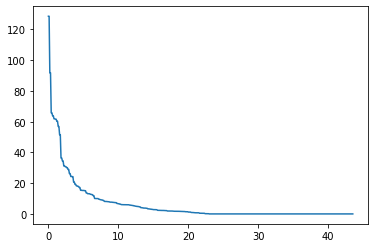

In [148]:
small_M_top = small_M.sum().sort_values(ascending=False)
x = np.arange(0,len(small_M_top)*0.1,0.1)
plt.plot(x,small_M_top)

In [63]:
small_M_top = small_M.sum().sort_values(ascending=False)

In [69]:
small_M_top[100]

6.60746891768597

In [ ]:
"""
def batchrun(version = 1):
    protein_file_path = './Dataset_pre_test/Docked_PDBs_receptors/*/.pdb'
    protein_files = glob.glob(protein_file_path)
    for p in protein_files:
        print(p)
        pdb = p.split("/")[2].split("_")[0]
        ligand_file_path = './14A_DOCKED_LIGANDS_addH_sdf/'+pdb+'/*.sdf'
        ligand_files = glob.glob(ligand_file_path)
        n = len(ligand_files)
        M = np.zeros((n, 2*N))
        i = 0
        s = [] #index as ligand name
        for l in ligand_files:  
            try:
                M[i,:] = GetECIF_VB(p, l)
                s.append(l.split("/")[-1])
                i+=1
            except:
                print("Error",p," i=",i,l)
        assert i == n # check that all ligand files have been processed
        df_p = pd.DataFrame(M)
        df_p.index = s
        if p == protein_files[0]:
            df = df_p
        else:
            df = pd.concat([df,df_p],axis=0)
        df.to_csv("./output/perserve_part_ECIF.csv")
        print(df.shape)
    colname = [(i[0]+"-"+i[1]).replace(";","") for i in product(ECIF_ProteinAtoms, ECIF_LigandAtoms)]*2 
    df = df.set_axis(colname, axis=1, inplace=False)
    df.to_csv("./output/total_ECIF.csv")
    if version == 2:
        small_M = VB_featurization_v2(df)
        small_M.to_csv("./output/small_ECIF_v2f.csv")
    else:
        small_M = VB_featurization_v1(df)
        small_M.to_csv("./output/small_ECIF_v1f.csv")
    return small_M

    
"""

In [214]:
N_select = 400 # Approx. no. of variables to keep
N = 1540 # len of ECIFs
df = batchrun()#default version=1
df

['./test_protein/ACE_protein_receptor.pdb', './test_protein/ACHE_protein_receptor.pdb']
['./test_ligand/ACHE/BDB8965_ACHE_active_ligand.sdf', './test_ligand/ACHE/BDB8961_ACHE_active_ligand.sdf', './test_ligand/ACE/BDB50017122_ACE_active_ligand.sdf', './test_ligand/ACE/BDB21642_ACE_active_ligand.sdf']


,C41300-Br11000,C41300-C33011,C41300-C41100,C41300-C41200,C41300-C41300,C41300-C42000,C41300-C42100,C41300-C42101,C41300-C42111,C41300-C42200,...,S22000-S21100,S22000-S22000,S22000-S22001,S22000-S22011,S22000-S33000,S22000-S33001,S22000-S43000,S22000-S64000,S22000-S64001,S22000-S74000
BDB50017122_ACE_active_ligand.sdf,0.0,0.0,0.0,0.0,0.678726,0.0,0.0,0.0,0.0,1.264378,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BDB21642_ACE_active_ligand.sdf,0.0,0.0,0.0,0.0,0.389659,0.0,0.0,0.0,0.0,0.909998,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BDB8965_ACHE_active_ligand.sdf,0.0,0.0,0.0,0.0,0.265863,0.0,0.0,0.0,0.0,0.516504,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BDB8961_ACHE_active_ligand.sdf,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
